Welcome to the world where fashion meets computer vision! This is a starter kernel that applies Mask R-CNN with COCO pretrained weights to the task of [iMaterialist (Fashion) 2019 at FGVC6](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6).

In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
DATA_DIR = Path('/home/ubuntu/efs/kaggle/imaterialist/')
ROOT_DIR = Path('/home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs')

# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights

In [3]:
'''
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel
'''

"\n!git clone https://www.github.com/matterport/Mask_RCNN.git\nos.chdir('Mask_RCNN')\n\n!rm -rf .git # to prevent an error when the kernel is committed\n!rm -rf images assets # to prevent displaying images at the bottom of a kernel\n"

In [4]:
print(ROOT_DIR/'Mask_RCNN')
sys.path.append("/home/ubuntu/github/Mask_RCNN/")
#sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs/Mask_RCNN


Using TensorFlow backend.


In [5]:
!ls ../mrcnn

config.py    model.py		__pycache__  visualize.py
__init__.py  parallel_model.py	utils.py


In [6]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-rw-r-- 1 ubuntu ubuntu 246M Nov 26  2017 mask_rcnn_coco.h5


# Set Config

Mask R-CNN has a load of hyperparameters. I only adjust some of them.

In [7]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet101'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

# Make Datasets

In [8]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [9]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.46%


Segments that contain attributes are only 3.46% of data, and [according to the host](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/90643#523135), 80% of images have no attribute. So, in the first step, we can only deal with categories to reduce the complexity of the task.

In [10]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  333415


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


Rows with the same image are grouped together because the subsequent operations perform in an image level.

In [11]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


Here is the custom function that resizes an image.

In [12]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

The crucial part is to create a dataset for this task.

In [13]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

Let's visualize some random images and their masks.

('/home/ubuntu/efs/kaggle/imaterialist/train/6ad1eb74fc4c239b531264d2010d7ab5.jpg', ['dress', 'neckline', 'belt', 'shoe', 'shoe'])


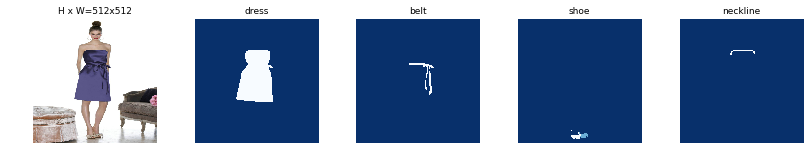

('/home/ubuntu/efs/kaggle/imaterialist/train/9b815a2c6a454ac6eb1b05216b0bcbf9.jpg', ['sock', 'sock', 'shoe', 'shoe', 'pants', 'neckline', 'top, t-shirt, sweatshirt', 'lapel', 'sleeve', 'sleeve', 'pocket', 'pocket', 'coat'])


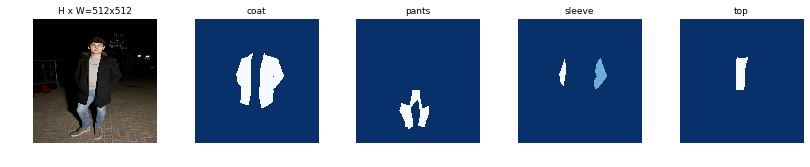

('/home/ubuntu/efs/kaggle/imaterialist/train/4852a87e762a35ea79632a2c910c7f66.jpg', ['shoe', 'shoe', 'sock', 'sock', 'skirt', 'pocket', 'pocket', 'jacket', 'lapel', 'sleeve', 'sleeve', 'pocket', 'pocket', 'scarf'])


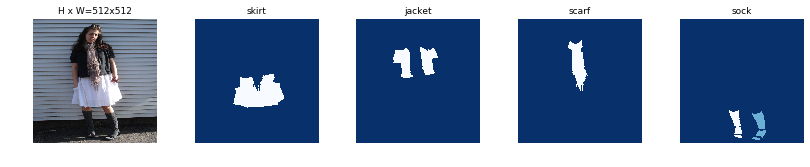

('/home/ubuntu/efs/kaggle/imaterialist/train/afebde99ec7d251dbf8375750e1b8e8d.jpg', ['glasses', 'dress', 'sleeve', 'neckline', 'sleeve', 'shoe', 'shoe'])


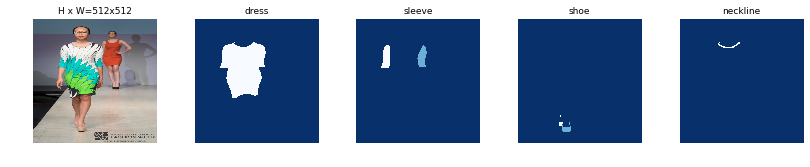

('/home/ubuntu/efs/kaggle/imaterialist/train/070cc1a88895dee78421cc40dc8dafee.jpg', ['jumpsuit', 'sleeve', 'sleeve', 'neckline', 'glasses', 'bead', 'bead', 'bead', 'bead', 'bead', 'sock', 'sock', 'shoe', 'shoe'])


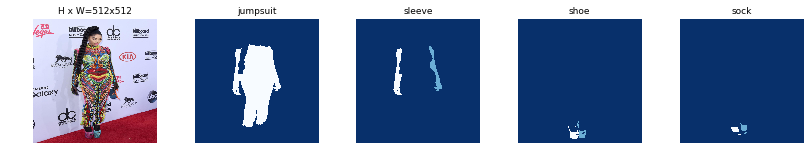

('/home/ubuntu/efs/kaggle/imaterialist/train/47780959f3d0b721ee306ef54b019fc1.jpg', ['neckline', 'sequin', 'sequin', 'pocket', 'pocket', 'pants', 'shoe', 'shoe', 'dress'])


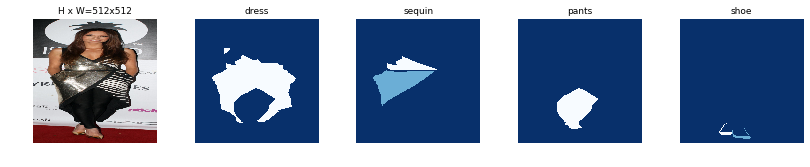

In [14]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

Now, the data are partitioned into train and validation sets.

In [15]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's visualize class distributions of the train and validation data.

Total train images:  36500
Total train segments:  267004


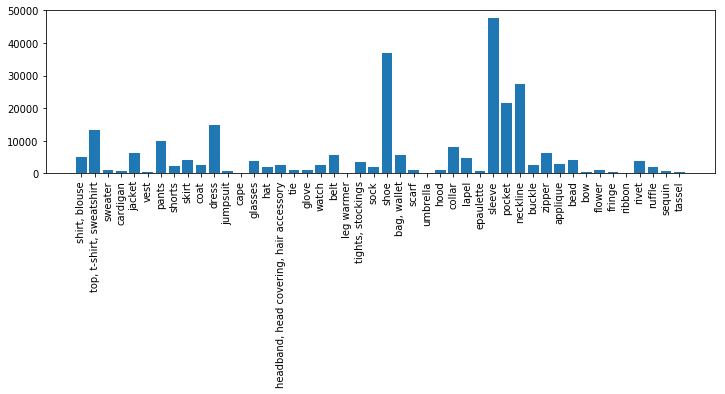

Total train images:  9125
Total validation segments:  66411


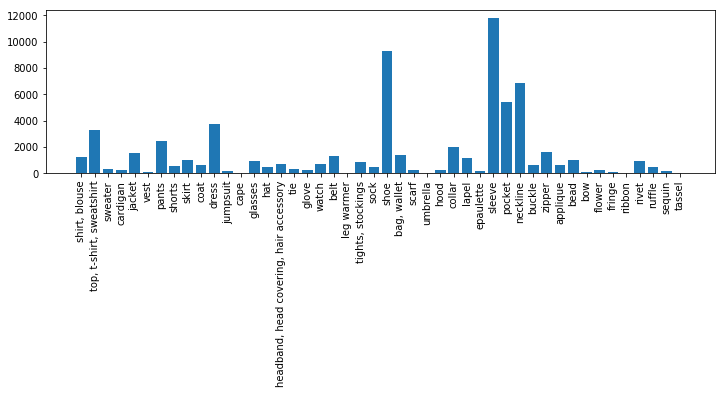

In [16]:
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, label_names, rotation='vertical')
plt.show()

# Train

In [17]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [3, 8, 12]

import warnings 
warnings.filterwarnings("ignore")

This section creates a Mask R-CNN model and specifies augmentations to be used.

In [18]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

First, we train only the heads.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /home/ubuntu/efs/kaggle/imaterialist/maskrcnn/logs/fashion20190530T2125/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (

Then, all layers are trained.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

Afterwards, we reduce LR and train again.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR/5,
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

Let's visualize training history and choose the best epoch.

In [ ]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

# Predict

The final step is to use our model to predict test data.

In [ ]:
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

This cell defines InferenceConfig and loads the best trained model.

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Then, load the submission data.

In [ ]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

Here is the main prediction steps, along with some helper functions.

In [ ]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [ ]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [ ]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

The submission file is created, when all predictions are ready.

In [ ]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False)

Finally, it's pleasing to visualize the results! Sample images contain both fashion models and predictions from the Mask R-CNN model.

In [ ]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

My code is largely based on [this Mask-RCNN kernel](https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155) and borrowed some ideas from [the U-Net Baseline kernel](https://www.kaggle.com/go1dfish/u-net-baseline-by-pytorch-in-fgvc6-resize). So, I would like to thank the kernel authors for sharing insights and programming techniques. Importantly, an image segmentation task can be accomplished with short code and good accuracy thanks to [Matterport's implementation](https://github.com/matterport/Mask_RCNN) and a deep learning line of researches culminating in [Mask R-CNN](https://arxiv.org/abs/1703.06870).

I am sorry that I published this kernel quite late, beyond the halfway of a timeline. I just started working for this competition about a week ago, and to my surprise, the score fell in the range of silver medals at that time. I have no dedicated GPU and no time to further tune the model, so I decided to make this kernel public as a starter guide for anyone who is interested to join this delightful competition.

<img src='https://i.imgur.com/j6LPLQc.png'>

Hope you guys like this kernel. If there are any bugs, please let me know.

P.S. When clicking 'Submit to Competition' button, I always run into 404 erros, so I have to save a submission file and upload it to the submission page for submitting. The public LB score of this kernel is around **0.07**.